Area = 19723.0


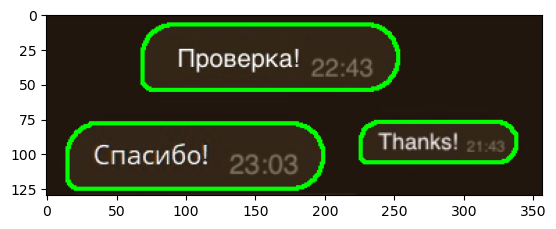

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# загрузка изображения и применение цветового фильтра в заданном цветовом диапазоне
image = cv2.imread(os.path.join('images', 'messages_example.jpeg'))
original = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower = np.array([0, 0, 40], dtype="uint8")
upper = np.array([255, 255, 255], dtype="uint8")
mask = cv2.inRange(image, lower, upper)
detected = cv2.bitwise_and(original, original, mask=mask)

# удаление шумов
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

# поиск контуров и суммарной площади занимаемой сообщениями области
contours = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
area = 0
for c in contours:
    area += cv2.contourArea(c)
    cv2.drawContours(original,[c], 0, (0,255,0), 2)

print('Area =', area)
plt.imshow(original)

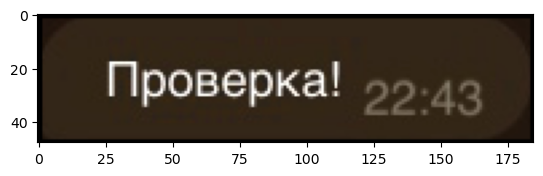

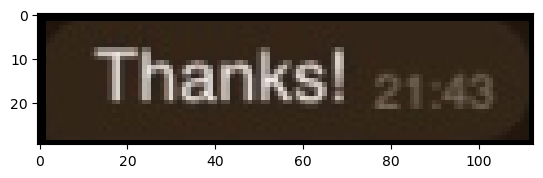

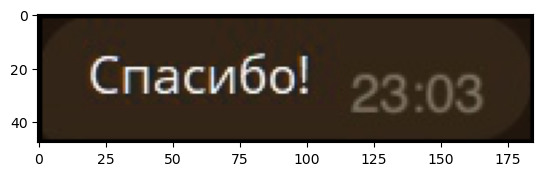

In [2]:
for contour in reversed(contours):

    # выделение и прорисовка прямоугольников с сообщениями
    x, y, w, h = cv2.boundingRect(contour)
    rect = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
     
    # вырезаем прямоугольники с сообщениями для дальнейшей OCR обработки
    cropped = image[y:y + h, x:x + w]

    cropped = cv2.cvtColor(cropped, cv2.COLOR_HSV2BGR)
    plt.imshow(cropped, cmap='gray', vmin=0, vmax=255)
    plt.show()